# Looking at videos with no detected faces

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#default_exp nb_02

In [ ]:
#export
from fastai.vision import *
from IPython.display import HTML
import cv2
import pandas as pd
from facenet_pytorch import MTCNN

from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01a import *
from kgl_deepfake.nb_01b import *

### Data

In [ ]:
SOURCE = Path('../../data/train_sample_videos/')

In [ ]:
annots = pd.read_csv('annots_noface.csv')

In [ ]:
annots.head()

,fname,label,split,original
0,adhsbajydo.mp4,FAKE,train,fysyrqfguw.mp4
1,agrmhtjdlk.mp4,REAL,train,NaN
2,andaxzscny.mp4,FAKE,train,fysyrqfguw.mp4
3,aorjvbyxhw.mp4,FAKE,train,bulkxhhknf.mp4
4,atvmxvwyns.mp4,REAL,train,NaN


In [ ]:
fnames = [SOURCE/o for o in annots.fname]
labels = [f'{o.fname} {o.label}' for i, o in annots.iterrows()]

In [ ]:
HTML(html_vids(fnames, titles=labels))

### Darkish videos

Many of these videos have poor lighting.  Let's consider these in this section.

In [ ]:
fn = 'atvmxvwyns.mp4'
#fn = 'aagfhgtpmv.mp4'
#fn = 'abarnvbtwb.mp4'

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

In [ ]:
def get_frame(fn):
    v_cap = cv2.VideoCapture(str(SOURCE/fn))
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    _ = v_cap.grab()
    success, frame = v_cap.retrieve()
    return frame

In [ ]:
frame = get_frame(fn)

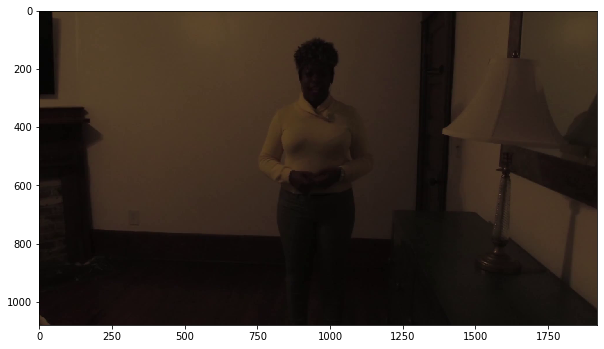

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

The image is too dark, which can pose problems for face detection.

### Solution 1: Dumb Histogram Equalization

A first solution may be to do histogram equalization (*Histogram equalization is a method in image processing of contrast adjustment using the image's histogram.*) to improve image contrast. The problem is that histogram equalization is usually performed on greyscale images and cannot be performed in the RGB color space as the 3 channels do not represent light intensity. To do HE on color images, we must first change the color space to a more appropriate one (e.g. YCrCb or YUV)

In [ ]:
hist = cv2.calcHist([frame], [0], None, [256], [0, 256])

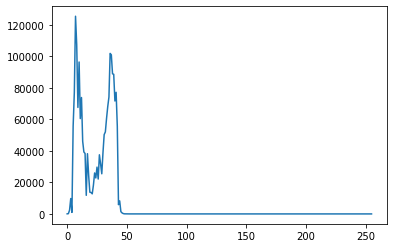

In [ ]:
plt.plot(hist)

When looking at the histogram of this image, we can see that most of the pixels have a very low value. In fact, no pixels has a value superior to 50. The goal of histogram equalization is then to *stretch* this histogram to better use the range of values available.

In [ ]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)

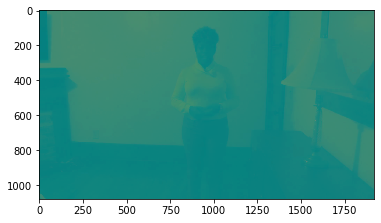

In [ ]:
# If we plot the image, it doesn't make any sense as we are not in RGB space anymore
plt.imshow(frame)

In [ ]:
frame_eq = frame.copy()

We can now equalize the Y (luminance) channel and replace the original one.

In [ ]:
frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:, 0])

In [ ]:
frame_eq = cv2.cvtColor(frame_eq, cv2.COLOR_YCrCb2RGB)

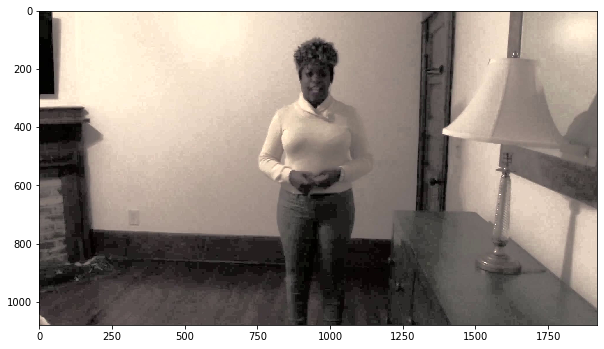

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(frame_eq)

In [ ]:
hist = cv2.calcHist([frame_eq], [0], None, [256], [0, 256])

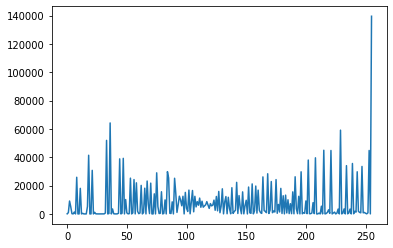

In [ ]:
plt.plot(hist)

This looks better ! But what happens when the image already had a good enough contrast ?

In [ ]:
fn = 'abarnvbtwb.mp4'

In [ ]:
frame = get_frame(fn)

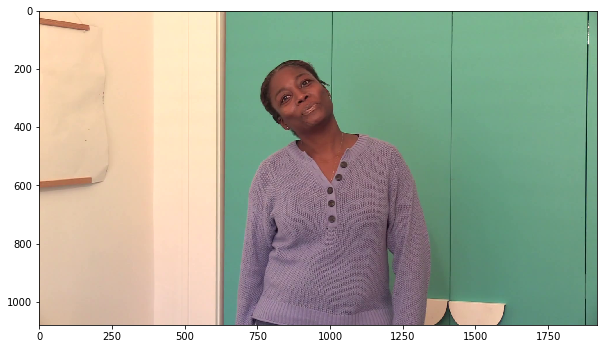

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
hist = cv2.calcHist([frame], [0], None, [256], [0, 256])

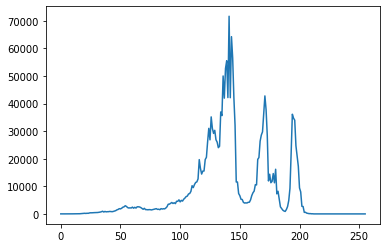

In [ ]:
plt.plot(hist)

In [ ]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)

In [ ]:
frame_eq = frame.copy()

In [ ]:
frame_eq[:,:,0] = cv2.equalizeHist(frame[:,:, 0])

In [ ]:
frame_eq = cv2.cvtColor(frame_eq, cv2.COLOR_YCrCb2RGB)

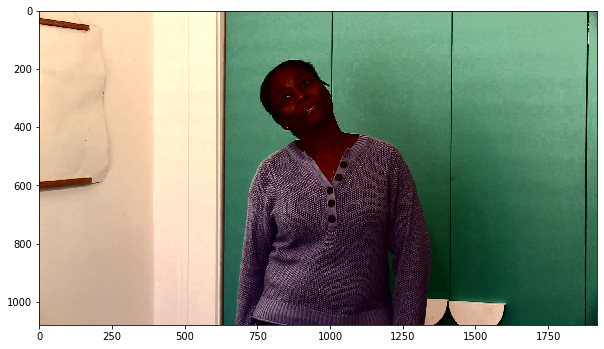

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(frame_eq)

In [ ]:
hist = cv2.calcHist([frame_eq], [0], None, [256], [0, 256])

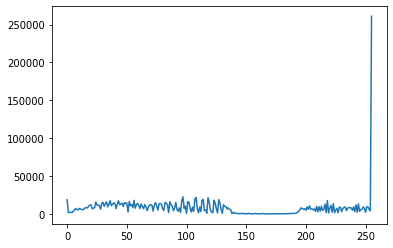

In [ ]:
plt.plot(hist)

Now the face is more difficult to see.

### Solution 2: CLAHE (Contrast Limited Adaptive Histogram Equalization)

With CLAHE, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.

In [ ]:
fn = 'atvmxvwyns.mp4'

In [ ]:
frame = get_frame(fn)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
frame[:,:,0] = clahe.apply(frame[:,:,0])

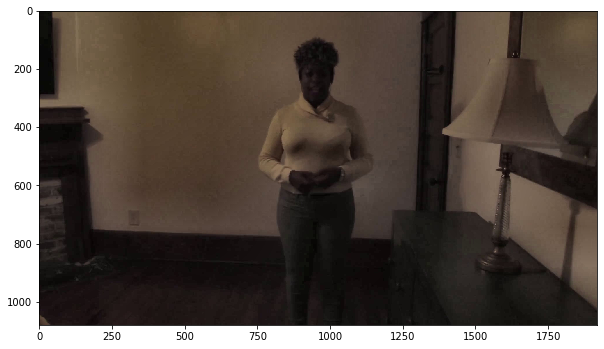

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_YCrCb2RGB))

In [ ]:
hist = cv2.calcHist([frame], [0], None, [256], [0, 256])

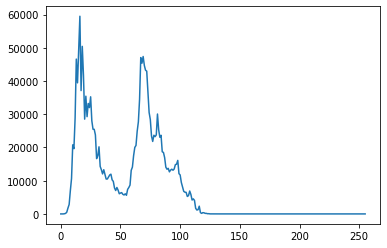

In [ ]:
plt.plot(hist)

This is again a little bit dark but still better than the original image ! Let's try with the other image, which had a good contrast

In [ ]:
fn = 'abarnvbtwb.mp4'

In [ ]:
frame = get_frame(fn)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
frame[:,:,0] = clahe.apply(frame[:,:,0])

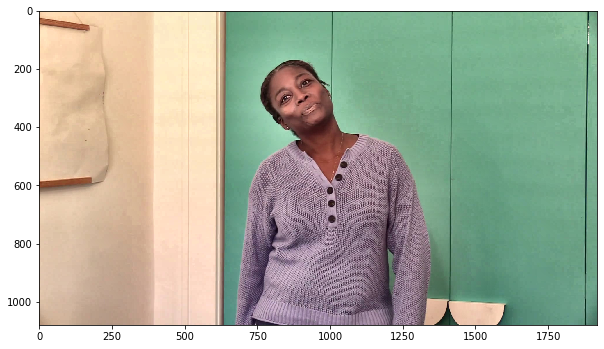

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_YCrCb2RGB))

In [ ]:
hist = cv2.calcHist([frame], [0], None, [256], [0, 256])

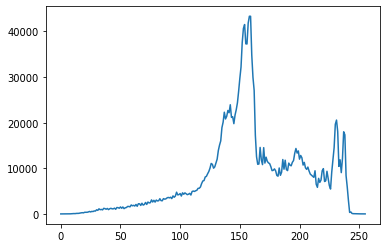

In [ ]:
plt.plot(hist)

Result is still good ! 

### Change the face detector

In [ ]:
#export
def get_first_face(detector, fn, resize=.5, equalize=False):
    '''
    Returns the first detected face from a video
    '''
    assert Path(fn).exists()
    v_cap = cv2.VideoCapture(str(fn))
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    iframe, face = None, None
    for i in range(v_len):
        _ = v_cap.grab()
        success, frame = v_cap.retrieve()
        if not success: continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
        if equalize:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            frame[:,:,0] = clahe.apply(frame[:,:,0])
        frame = cv2.cvtColor(frame, cv2.COLOR_YCrCb2RGB)
        frame = PIL.Image.fromarray(frame)
        if resize is not None: frame = frame.resize([int(d * resize) for d in frame.size])
        face = detector(frame)
        if face is not None:
            iframe = i
            break
    v_cap.release()
    return iframe, face

In [ ]:
fn = 'atvmxvwyns.mp4'

In [ ]:
face = get_first_face(detector, SOURCE/fn)

In [ ]:
Image(face[1].type(torch.uint8))

In [ ]:
face[0]

In [ ]:
face = get_first_face(detector, SOURCE/fn, equalize=True)

In [ ]:
Image(face[1].type(torch.uint8))

In [ ]:
face[0]

Now the face detector with equalization is able to detect the face in the very first frame, which wasn't possible without.

In [ ]:
fn = 'abarnvbtwb.mp4'

In [ ]:
face = get_first_face(detector, SOURCE/fn)

In [ ]:
Image(face[1].type(torch.uint8))

In [ ]:
face[0]

In [ ]:
face = get_first_face(detector, SOURCE/fn, equalize=True)

In [ ]:
Image(face[1].type(torch.uint8))

In [ ]:
face[0]

Here the face was already detected in the first frame, but we can see that there is now a difference in the crop size, where the face with equalization has more details (ears, chin,...)

# - fin

In [ ]:
from nbdev.export import *
notebook2script()